# 1. Carregamento das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re

# 2. Exploração dos dados

Este capítulo do Notebook apresenta como foram tratados os dados para posterior análise.

## 2.1. Conhecendo o DF, prévia e tipo dos dados

In [2]:
#Conhecendo o DF
df= pd.read_csv('dados_finais.csv')

print('shape:', df.shape)


shape: (5565, 49)


In [3]:
#Conhecendo uma prévia dos dados
df.head(10)

,ID,UF,NOMEMUN,S1,P1,ED1,EC1,SCO,TPM,DDM,...,T_LUZ,HOMEMTOT,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R
0,1100015,11,ALTA FLORESTA D'OESTE,0.848649,0.089251,0.952801,0.939816,0.707630,24392,3.45,...,93.98,12656,11736,10611,10422,13970,0.641,0.526,0.763,0.657
1,1100023,11,ARIQUEMES,0.947084,0.111816,0.994876,0.951571,0.751337,90353,20.41,...,98.58,45543,44810,45300,13828,76525,0.702,0.600,0.806,0.716
2,1100031,11,CABIXI,1.000000,0.114323,0.941632,0.965374,0.755332,6313,4.80,...,96.36,3266,3047,2869,3620,2693,0.650,0.559,0.757,0.650
3,1100049,11,CACOAL,0.898241,0.173867,1.000000,0.932261,0.751092,78574,20.72,...,98.89,39124,39450,40083,16653,61921,0.718,0.620,0.821,0.727
4,1100056,11,CEREJEIRAS,0.961538,0.114323,0.995794,0.929559,0.750303,17029,6.12,...,98.85,8551,8478,8699,2610,14419,0.692,0.602,0.799,0.688
5,1100064,11,COLORADO DO OESTE,0.841727,0.145662,0.987143,0.930392,0.726231,18591,12.81,...,97.76,9330,9261,8851,4934,13657,0.685,0.584,0.814,0.676
6,1100072,11,CORUMBIARA,0.980392,0.089251,0.968137,0.955080,0.748215,8783,2.87,...,97.81,4711,4072,4251,6193,2590,0.613,0.473,0.774,0.630
7,1100080,11,COSTA MARQUES,0.893048,0.114323,0.972368,0.949011,0.732188,13678,2.74,...,90.13,7202,6476,6266,6181,7497,0.611,0.493,0.751,0.616
8,1100098,11,ESPIGÃO D'OESTE,0.944444,0.145662,0.988418,0.940724,0.754812,28729,6.36,...,96.70,14606,14123,15107,8119,20610,0.672,0.536,0.819,0.691
9,1100106,11,GUAJARÁ-MIRIM,0.961460,0.145662,0.998647,0.946045,0.762954,41656,1.68,...,97.71,20947,20709,16920,6449,35207,0.657,0.519,0.823,0.663


In [4]:
#Setando o ID como index do DF
df.set_index('ID', inplace=True, drop=True)

In [5]:
#checando os nomes das colunas
df.columns 

Index(['UF', 'NOMEMUN', 'S1', 'P1', 'ED1', 'EC1', 'SCO', 'TPM', 'DDM', 'SMM',
       'POM', 'TPO', 'RSA', 'TXE', 'IDEBI', 'IDEBF', 'PIB', 'RFE', 'RER',
       'DEM', 'OPNV', 'IMH', 'AUT', 'ESA', 'AVP', 'UVP', 'ESPVIDA', 'T_ENV',
       'E_ANOSESTUDO', 'T_ANALF15M', 'GINI', 'PIND', 'PMPOB', 'PPOB', 'RDPC',
       'T_AGUA', 'T_DENS', 'T_LIXO', 'T_LUZ', 'HOMEMTOT', 'MULHERTOT', 'PEA',
       'pesoRUR', 'pesourb', 'IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R'],
      dtype='object')

In [6]:
#checando os tipos dos dados
df.dtypes

UF                int64
NOMEMUN          object
S1              float64
P1              float64
ED1             float64
EC1             float64
SCO             float64
TPM               int64
DDM             float64
SMM             float64
POM             float64
TPO             float64
RSA             float64
TXE             float64
IDEBI           float64
IDEBF           float64
PIB             float64
RFE             float64
RER             float64
DEM             float64
OPNV            float64
IMH             float64
AUT             float64
ESA             float64
AVP             float64
UVP             float64
ESPVIDA         float64
T_ENV           float64
E_ANOSESTUDO    float64
T_ANALF15M      float64
GINI            float64
PIND            float64
PMPOB           float64
PPOB            float64
RDPC            float64
T_AGUA          float64
T_DENS          float64
T_LIXO          float64
T_LUZ           float64
HOMEMTOT          int64
MULHERTOT         int64
PEA             

In [7]:
df.describe()

,UF,S1,P1,ED1,EC1,SCO,TPM,DDM,SMM,POM,...,T_LUZ,HOMEMTOT,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R
count,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5.565000e+03,5565.000000,5565.000000,5.565000e+03,...,5565.000000,5.565000e+03,5.565000e+03,5.565000e+03,5565.000000,5.565000e+03,5565.000000,5565.000000,5565.000000,5565.000000
mean,32.372327,0.916115,0.143307,0.982867,0.951950,0.748560,3.427777e+04,108.202577,2.017934,9.382440e+03,...,97.189614,1.678472e+04,1.749305e+04,1.686272e+04,5360.288769,2.891748e+04,0.659157,0.559094,0.801564,0.642873
std,9.829957,0.116368,0.065909,0.024358,0.016225,0.036039,2.031126e+05,572.117006,0.484922,9.340953e+04,...,6.024377,9.610372e+04,1.070224e+05,1.070601e+05,6641.675014,2.015510e+05,0.071997,0.093328,0.044681,0.080662
min,11.000000,0.000000,0.024990,0.742678,0.881809,0.487972,8.050000e+02,0.130000,0.800000,5.900000e+01,...,27.410000,4.220000e+02,3.830000e+02,3.070000e+02,0.000000,1.740000e+02,0.418000,0.207000,0.672000,0.400000
25%,25.000000,0.868597,0.096144,0.977262,0.941617,0.733116,5.235000e+03,11.570000,1.700000,5.640000e+02,...,97.650000,2.671000e+03,2.574000e+03,2.386000e+03,1599.000000,2.839000e+03,0.599000,0.490000,0.769000,0.572000
50%,31.000000,0.961702,0.149827,0.989976,0.951321,0.754317,1.093400e+04,24.380000,1.900000,1.233000e+03,...,99.390000,5.548000e+03,5.419000e+03,4.933000e+03,3233.000000,6.263000e+03,0.665000,0.560000,0.808000,0.654000
75%,41.000000,1.000000,0.182075,0.998915,0.962437,0.773103,2.342400e+04,51.670000,2.200000,3.536000e+03,...,99.870000,1.175800e+04,1.170700e+04,1.061400e+04,6767.000000,1.548400e+04,0.718000,0.631000,0.836000,0.707000
max,53.000000,1.000000,0.509624,1.000000,1.000000,0.850899,1.125350e+07,13024.560000,6.500000,5.571893e+06,...,100.000000,5.328632e+06,5.924871e+06,6.026212e+06,125336.000000,1.115234e+07,0.862000,0.825000,0.894000,0.891000


## 2.2. Verificação de dados duplicados, checagens e tratamentos

In [8]:
# Verificando se há dados de index duplicados
df[df.index.duplicated()==True]

,UF,NOMEMUN,S1,P1,ED1,EC1,SCO,TPM,DDM,SMM,...,T_LUZ,HOMEMTOT,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R
ID,,,,,,,,,,,,,,,,,,,,,


In [9]:
#validando se o número total de homens+mulheres bate com o total da população
df[(df['HOMEMTOT']+df['MULHERTOT']) !=df['TPM']]

,UF,NOMEMUN,S1,P1,ED1,EC1,SCO,TPM,DDM,SMM,...,T_LUZ,HOMEMTOT,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R
ID,,,,,,,,,,,,,,,,,,,,,


In [10]:
#verificando se as colunas da raspagem de dados há dados duplicados:
colunas=['TPM', 'DDM', 'SMM',
       'POM', 'TPO', 'RSA', 'TXE', 'IDEBI', 'IDEBF', 'PIB', 'RFE', 'RER',
       'DEM', 'OPNV', 'IMH', 'AUT', 'ESA', 'AVP', 'UVP']
df[df.duplicated(colunas)==True]

,UF,NOMEMUN,S1,P1,ED1,EC1,SCO,TPM,DDM,SMM,...,T_LUZ,HOMEMTOT,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R
ID,,,,,,,,,,,,,,,,,,,,,


Não foram verificados dados duplicados e/ou discrepantes entre as bases pesquisadas (Atlas Brasil e IBGE).

## 2.3. Verificação de dados faltantes

In [11]:
#verificando dados faltantes (por atributo)
df.isna().sum()

UF                 0
NOMEMUN            0
S1                 0
P1                 0
ED1                0
EC1                0
SCO                0
TPM                0
DDM                0
SMM                0
POM                0
TPO                0
RSA                0
TXE                0
IDEBI             92
IDEBF            107
PIB                0
RFE              568
RER                0
DEM                0
OPNV            1416
IMH              450
AUT                0
ESA                0
AVP               14
UVP                0
ESPVIDA            0
T_ENV              0
E_ANOSESTUDO       0
T_ANALF15M         0
GINI               0
PIND               0
PMPOB              0
PPOB               0
RDPC               0
T_AGUA             0
T_DENS             0
T_LIXO             0
T_LUZ              0
HOMEMTOT           0
MULHERTOT          0
PEA                0
pesoRUR            0
pesourb            0
IDHM               0
IDHM_E             0
IDHM_L             0
IDHM_R       

In [12]:
#Total de registros faltantes no dataset
df.isna().sum().sum()

2647

In [13]:
#preenchendo os dados faltantes com a média dos valores:
df.fillna(df.mean(),inplace=True)

In [14]:
df.isna().sum().sum()

0

In [15]:
#Descrição da coluna de Score (GGI):
df['SCO'].describe()

count    5565.000000
mean        0.748560
std         0.036039
min         0.487972
25%         0.733116
50%         0.754317
75%         0.773103
max         0.850899
Name: SCO, dtype: float64

## 2.4. Normalização dos dados

Antes da aplicação do modelo, faz-se necessária a normalização dos dados. Além disso, como os atributos S1, P1, ED1 e EC1 são usados para compor o indice de igualdade de gênero GGI (variável SCO).


In [16]:
n = df.iloc[:,6:]
n

,SCO,TPM,DDM,SMM,POM,TPO,RSA,TXE,IDEBI,IDEBF,...,T_LUZ,HOMEMTOT,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R
ID,,,,,,,,,,,,,,,,,,,,,
1100015,0.707630,24392,3.45,1.8,3271.0,14.1,41.8,95.7,6.2,4.8,...,93.98,12656,11736,10611,10422,13970,0.641,0.526,0.763,0.657
1100023,0.751337,90353,20.41,2.0,19886.0,18.7,35.0,97.2,5.5,4.9,...,98.58,45543,44810,45300,13828,76525,0.702,0.600,0.806,0.716
1100031,0.755332,6313,4.80,1.8,607.0,11.2,41.4,98.1,6.1,5.1,...,96.36,3266,3047,2869,3620,2693,0.650,0.559,0.757,0.650
1100049,0.751092,78574,20.72,2.0,19942.0,23.5,35.6,97.6,6.3,5.1,...,98.89,39124,39450,40083,16653,61921,0.718,0.620,0.821,0.727
1100056,0.750303,17029,6.12,2.0,2482.0,15.1,35.7,98.5,6.4,5.3,...,98.85,8551,8478,8699,2610,14419,0.692,0.602,0.799,0.688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5222005,0.736929,12548,13.15,2.1,2317.0,16.9,31.7,98.6,6.4,5.4,...,99.83,6297,6251,6657,3378,9170,0.712,0.622,0.818,0.710
5222054,0.758423,7371,10.00,2.7,1923.0,22.3,33.0,99.1,6.7,5.8,...,99.70,3873,3498,3922,1050,6321,0.684,0.562,0.804,0.707
5222203,0.746885,4735,4.47,1.9,885.0,14.7,38.0,96.0,5.0,4.1,...,99.78,2588,2147,2008,1233,3502,0.647,0.534,0.818,0.619


In [17]:
from sklearn.preprocessing import MinMaxScaler
# Separando os valores no Dataset
n = df.iloc[:,6:].values


# normalizando os atributos
n = MinMaxScaler().fit_transform(n)

print(n)

[[6.05238286e-01 2.09611953e-03 2.54905589e-04 ... 5.16181230e-01
  4.09909910e-01 5.23421589e-01]
 [7.25667606e-01 7.95791374e-03 1.55707390e-03 ... 6.35922330e-01
  6.03603604e-01 6.43584521e-01]
 [7.36677094e-01 4.89482611e-04 3.58556958e-04 ... 5.69579288e-01
  3.82882883e-01 5.09164969e-01]
 ...
 [7.13402399e-01 3.49249576e-04 3.33219957e-04 ... 5.29126214e-01
  6.57657658e-01 4.46028513e-01]
 [7.27477011e-01 3.85685282e-04 1.71216706e-04 ... 4.82200647e-01
  5.85585586e-01 4.66395112e-01]
 [7.92249284e-01 2.28332352e-01 3.41304763e-02 ... 8.65695793e-01
  9.05405405e-01 9.42973523e-01]]


## 2.5. Padronização dos dados

In [18]:
from sklearn.preprocessing import StandardScaler


# Separando os valores no Dataset
p = df.iloc[:,6:].values


# padronizando os atributos
p = StandardScaler().fit_transform(p)

print(p)


[[-1.13583491e+00 -4.86757535e-02 -1.83112875e-01 ... -3.54631450e-01
  -8.63185844e-01  1.75153000e-01]
 [ 7.70560519e-02  2.76104294e-01 -1.53465925e-01 ...  4.38344405e-01
   9.92813946e-02  9.06668980e-01]
 [ 1.87936930e-01 -1.37693483e-01 -1.80753006e-01 ... -1.00708184e-03
  -9.97483598e-01  8.83629686e-02]
 ...
 [-4.64716574e-02 -1.45463270e-01 -1.81329863e-01 ... -2.68904330e-01
   3.67876903e-01 -2.95992885e-01]
 [ 9.52792836e-02 -1.43444504e-01 -1.85018251e-01 ... -5.79665138e-01
   9.74955844e-03 -1.72007126e-01]
 [ 7.47626280e-01  1.24862260e+01  5.88144826e-01 ...  1.96000078e+00
   1.59893965e+00  2.72925964e+00]]


# 3. Aplicação do modelo

## 3.1. K-Means 

### 3.1.1 - K-Means para dados normalizados

1 4549.158077606059
2 2496.996569031352
3 2157.534490076922
4 2002.43287814721
5 1871.693132205124
6 1768.542996870857
7 1693.9373707635443
8 1636.658436514569
9 1586.9914261376646
10 1539.4806682626045


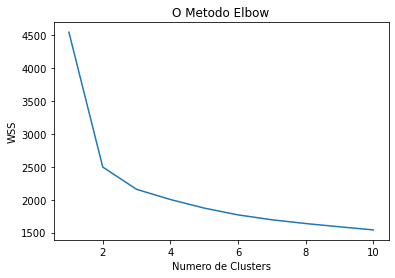

In [19]:
from sklearn.cluster import KMeans
wcss = []
 
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=1234)
    kmeans.fit(n)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)  
plt.plot(range(1, 11), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

Com a avaliação do método Elbow, percebe-se que o número de clusters ideais para este dataset é 2.

In [20]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state=1234)

kmeans.fit(n)
kmeans.cluster_centers_

array([[7.41650500e-01, 1.51952870e-03, 2.96958679e-03, 1.73355037e-01,
        3.01155352e-04, 5.55860727e-02, 6.64960917e-01, 9.23592420e-01,
        3.35854969e-01, 3.70017733e-01, 2.44332281e-02, 9.09661259e-01,
        8.00498487e-04, 7.70224058e-04, 5.68869607e-02, 4.13730848e-02,
        1.31519124e-02, 2.23345979e-01, 6.30155337e-01, 6.56785980e-02,
        4.03287841e-01, 3.28711123e-01, 5.28191080e-01, 5.61151887e-01,
        4.81887391e-01, 3.19548978e-01, 5.23308991e-01, 7.19463181e-01,
        9.43868907e-02, 7.57696793e-01, 3.86371694e-01, 8.85787670e-01,
        9.20938075e-01, 1.61013692e-03, 1.43803986e-03, 1.14194559e-03,
        6.08857807e-02, 9.05529356e-04, 3.89631281e-01, 4.45053882e-01,
        4.02747283e-01, 3.37301111e-01],
       [6.99764345e-01, 4.09841951e-03, 1.24125324e-02, 2.44809476e-01,
        2.73302652e-03, 1.48297080e-01, 3.60170181e-01, 9.53746333e-01,
        5.43362939e-01, 5.43222348e-01, 7.81319294e-02, 8.12197724e-01,
        3.08039296e-03,

In [21]:
distance = kmeans.fit_transform(n)
distance

array([[0.7505325 , 1.01662088],
       [1.12439052, 0.77127831],
       [0.96023905, 1.06434811],
       ...,
       [0.80503271, 0.89831451],
       [0.79156276, 0.8833199 ],
       [2.2566538 , 1.50123111]])

In [22]:
labels = kmeans.labels_
nl=labels
nl

array([0, 1, 0, ..., 0, 0, 1])

In [23]:
df['Cluster-Normalizado']=pd.Series(nl).values

In [24]:
df.head()

,UF,NOMEMUN,S1,P1,ED1,EC1,SCO,TPM,DDM,SMM,...,HOMEMTOT,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R,Cluster-Normalizado
ID,,,,,,,,,,,,,,,,,,,,,
1100015,11,ALTA FLORESTA D'OESTE,0.848649,0.089251,0.952801,0.939816,0.707630,24392,3.45,1.8,...,12656,11736,10611,10422,13970,0.641,0.526,0.763,0.657,0
1100023,11,ARIQUEMES,0.947084,0.111816,0.994876,0.951571,0.751337,90353,20.41,2.0,...,45543,44810,45300,13828,76525,0.702,0.600,0.806,0.716,1
1100031,11,CABIXI,1.000000,0.114323,0.941632,0.965374,0.755332,6313,4.80,1.8,...,3266,3047,2869,3620,2693,0.650,0.559,0.757,0.650,0
1100049,11,CACOAL,0.898241,0.173867,1.000000,0.932261,0.751092,78574,20.72,2.0,...,39124,39450,40083,16653,61921,0.718,0.620,0.821,0.727,1
1100056,11,CEREJEIRAS,0.961538,0.114323,0.995794,0.929559,0.750303,17029,6.12,2.0,...,8551,8478,8699,2610,14419,0.692,0.602,0.799,0.688,1


In [25]:
df.groupby(['Cluster-Normalizado']).count()

,UF,NOMEMUN,S1,P1,ED1,EC1,SCO,TPM,DDM,SMM,...,T_LUZ,HOMEMTOT,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R
Cluster-Normalizado,,,,,,,,,,,,,,,,,,,,,
0,2424,2424,2424,2424,2424,2424,2424,2424,2424,2424,...,2424,2424,2424,2424,2424,2424,2424,2424,2424,2424
1,3141,3141,3141,3141,3141,3141,3141,3141,3141,3141,...,3141,3141,3141,3141,3141,3141,3141,3141,3141,3141


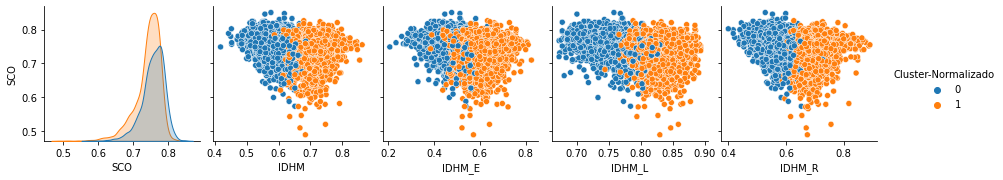

In [26]:
import seaborn as sns
sns.pairplot(df,
            x_vars=['SCO','IDHM','IDHM_E','IDHM_L','IDHM_R'],
            y_vars= ['SCO'], hue='Cluster-Normalizado')

### 3.1.2. K-Means para dados padronizados

1 233730.0000000007
2 168756.7028132096
3 137625.39474126004
4 127044.60358023841
5 118772.97545536398
6 111468.92360628612
7 106950.59925411773
8 104348.01964850724
9 100886.11521851411
10 98279.11250699355


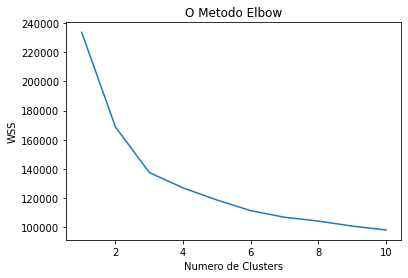

In [27]:
from sklearn.cluster import KMeans
wcss = []
 
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=1234)
    kmeans.fit(p)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)  
plt.plot(range(1, 11), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

Com a avaliação do método Elbow, percebe-se que o número de clusters ideais para este dataset é 3.

In [28]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state=1234)

kmeans.fit(p)
kmeans.cluster_centers_

array([[-1.83069690e-01,  3.28433560e-02,  8.50344775e-02,
         3.72135056e-01,  3.51907781e-02,  5.16884704e-01,
        -7.48877708e-01,  2.44369153e-01,  5.83961491e-01,
         5.18510369e-01,  3.89286379e-01, -3.99731080e-01,
         3.14113883e-02,  2.64570341e-02, -2.70413576e-02,
        -1.57784159e-01, -1.01980344e-01,  4.65930484e-01,
         1.38545078e-01,  4.30135004e-01,  6.91142461e-01,
         2.26542516e-01,  4.60093339e-01, -7.20244416e-01,
        -4.26314606e-01, -7.16051373e-01, -7.72001151e-01,
        -7.72230040e-01,  6.75469569e-01,  5.16305089e-01,
        -5.70909783e-01,  3.85099732e-01,  3.76593931e-01,
         3.31634172e-02,  3.25517934e-02,  4.08962304e-02,
        -2.83178107e-01,  4.24293419e-02,  7.33261059e-01,
         6.43706098e-01,  6.91130798e-01,  7.38050720e-01],
       [ 2.36018819e-01, -7.79522700e-02, -1.18841078e-01,
        -4.84640398e-01, -8.11045315e-02, -6.69971410e-01,
         9.68389692e-01, -3.15544305e-01, -7.54882974e-

In [29]:
distance = kmeans.fit_transform(p)
distance

array([[  5.55447282,   4.39363753, 125.28389278],
       [  4.29562429,   6.64917925, 124.284737  ],
       [  5.10616406,   5.08939993, 125.53362216],
       ...,
       [  6.35636256,   6.20699685, 125.60538013],
       [  5.30412004,   5.26087878, 125.59589632],
       [ 35.39575417,  36.85919761,  99.56266246]])

In [30]:
labels = kmeans.labels_
pl=labels
pl

array([1, 0, 1, ..., 1, 1, 0])

In [31]:
df['Cluster-Padronizado']=pd.Series(pl).values

In [32]:
df.groupby(['Cluster-Padronizado']).count()

,UF,NOMEMUN,S1,P1,ED1,EC1,SCO,TPM,DDM,SMM,...,HOMEMTOT,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R,Cluster-Normalizado
Cluster-Padronizado,,,,,,,,,,,,,,,,,,,,,
0,3136,3136,3136,3136,3136,3136,3136,3136,3136,3136,...,3136,3136,3136,3136,3136,3136,3136,3136,3136,3136
1,2427,2427,2427,2427,2427,2427,2427,2427,2427,2427,...,2427,2427,2427,2427,2427,2427,2427,2427,2427,2427
2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


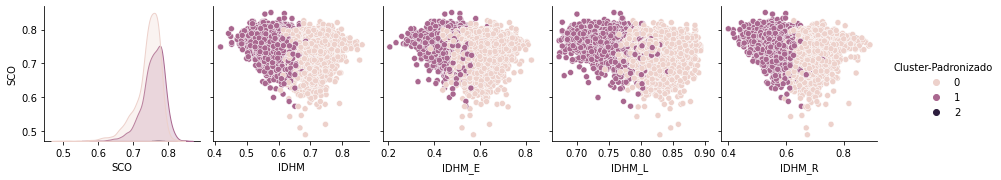

In [33]:
sns.pairplot(df,
            x_vars=['SCO','IDHM','IDHM_E','IDHM_L','IDHM_R'],
            y_vars= ['SCO'], hue='Cluster-Padronizado')

## 3.2. PCA + K-Means

Como alternativa a primeira hipótese (de se trabalhar com todos os atributos), esta parte do estudo verificará se é viável uma redução de variáveis através da análise de Componentes principais (PCA). Como estamos lidando com atributos de diferentes naturezas e grandezas, a alternativa escolhida para tratar os dados foi seguir com os dados normalizados.

In [34]:
from sklearn.decomposition import PCA

pca=PCA(n_components=42) #um exemplo com as 42 variáveis, mostrando que as outras não são muito representativas
N=pca.fit_transform(n)

pca.explained_variance_ratio_ 

array([5.78773188e-01, 9.37559925e-02, 7.20699863e-02, 3.89201679e-02,
       3.05800386e-02, 2.66092046e-02, 2.30518828e-02, 1.70825361e-02,
       1.57121286e-02, 1.26240114e-02, 1.14875471e-02, 9.90912857e-03,
       9.23908459e-03, 6.96623382e-03, 6.55899420e-03, 5.82901408e-03,
       5.36280248e-03, 4.92407355e-03, 4.51157262e-03, 3.70668307e-03,
       3.23955248e-03, 2.92863292e-03, 2.84488288e-03, 2.62372481e-03,
       1.92355629e-03, 1.84251698e-03, 1.61953100e-03, 1.49850759e-03,
       1.24408541e-03, 1.07476909e-03, 9.63594160e-04, 3.57831991e-04,
       1.18835153e-04, 2.93900487e-05, 7.49722860e-06, 6.98263276e-06,
       1.00814254e-06, 5.36464311e-07, 2.30314601e-07, 6.33888928e-08,
       1.14142885e-31, 4.93702240e-33])

Neste caso, para se obter uma variância acumulada de 99%, foi preciso selecionar 25 componentes principais.

In [35]:
pca=PCA(n_components=25) 
N=pca.fit_transform(n)

pca.explained_variance_ratio_.sum()

0.9912346204000905

1 4509.2829801958405
2 2457.200403310625
3 2117.787118778213
4 1962.6674371979823
5 1832.17323196042
6 1728.9319492151694
7 1654.3635122153726
8 1597.166534588917
9 1547.1525517379998
10 1499.91586562619


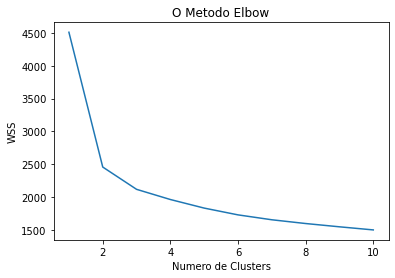

In [36]:
wcss = []
 
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=1234)
    kmeans.fit(N)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)  
plt.plot(range(1, 11), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

In [37]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state=1234)

kmeans.fit(N)
kmeans.cluster_centers_

array([[-5.33389942e-01,  1.50256469e-03,  1.92053336e-02,
        -2.67164027e-03,  1.83928213e-03,  1.59284197e-03,
        -3.12819015e-03,  6.01234644e-03, -5.04913821e-04,
         8.71342075e-04,  3.34042967e-03,  4.40489113e-03,
        -1.33315927e-03,  5.76053075e-05,  1.30720066e-04,
        -1.16651519e-03, -6.40424389e-04,  2.44010366e-04,
         3.69835890e-03,  1.44284453e-03,  8.33268436e-05,
        -5.64706665e-04, -1.31178789e-03, -3.21836280e-04,
         8.68549581e-04],
       [ 6.90152938e-01, -1.94416758e-03, -2.48497701e-02,
         3.45683381e-03, -2.37984609e-03, -2.06097730e-03,
         4.04756343e-03, -7.77937159e-03,  6.53307702e-04,
        -1.12742901e-03, -4.32218003e-03, -5.69948610e-03,
         1.72497401e-03, -7.45354741e-05, -1.69138618e-04,
         1.50935333e-03,  8.28644748e-04, -3.15724872e-04,
        -4.78530445e-03, -1.86689571e-03, -1.07816555e-04,
         7.30673629e-04,  1.69732160e-03,  4.16423776e-04,
        -1.12381580e-03]])

In [38]:
distance = kmeans.fit_transform(N)
distance

array([[1.01632366, 0.7497591 ],
       [0.77027318, 1.12346817],
       [1.06436056, 0.95999197],
       ...,
       [0.88189437, 0.78645354],
       [0.87407776, 0.78081756],
       [1.4592297 , 2.22931898]])

In [39]:
labels = kmeans.labels_
Nl=labels
Nl

array([1, 0, 1, ..., 1, 1, 0])

In [40]:
df['Cluster-PCA-Normalizado']=pd.Series(Nl).values

In [41]:
df.head()

,UF,NOMEMUN,S1,P1,ED1,EC1,SCO,TPM,DDM,SMM,...,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R,Cluster-Normalizado,Cluster-Padronizado,Cluster-PCA-Normalizado
ID,,,,,,,,,,,,,,,,,,,,,
1100015,11,ALTA FLORESTA D'OESTE,0.848649,0.089251,0.952801,0.939816,0.707630,24392,3.45,1.8,...,10611,10422,13970,0.641,0.526,0.763,0.657,0,1,1
1100023,11,ARIQUEMES,0.947084,0.111816,0.994876,0.951571,0.751337,90353,20.41,2.0,...,45300,13828,76525,0.702,0.600,0.806,0.716,1,0,0
1100031,11,CABIXI,1.000000,0.114323,0.941632,0.965374,0.755332,6313,4.80,1.8,...,2869,3620,2693,0.650,0.559,0.757,0.650,0,1,1
1100049,11,CACOAL,0.898241,0.173867,1.000000,0.932261,0.751092,78574,20.72,2.0,...,40083,16653,61921,0.718,0.620,0.821,0.727,1,0,0
1100056,11,CEREJEIRAS,0.961538,0.114323,0.995794,0.929559,0.750303,17029,6.12,2.0,...,8699,2610,14419,0.692,0.602,0.799,0.688,1,0,0


In [45]:
df.groupby(['Cluster-PCA-Normalizado']).count()

,UF,NOMEMUN,S1,P1,ED1,EC1,SCO,TPM,DDM,SMM,...,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R,Cluster-Normalizado,Cluster-Padronizado
Cluster-PCA-Normalizado,,,,,,,,,,,,,,,,,,,,,
0,3141,3141,3141,3141,3141,3141,3141,3141,3141,3141,...,3141,3141,3141,3141,3141,3141,3141,3141,3141,3141
1,2424,2424,2424,2424,2424,2424,2424,2424,2424,2424,...,2424,2424,2424,2424,2424,2424,2424,2424,2424,2424


Para a combinação PCA+K-means, também foram identificados 2 grupos distintos.

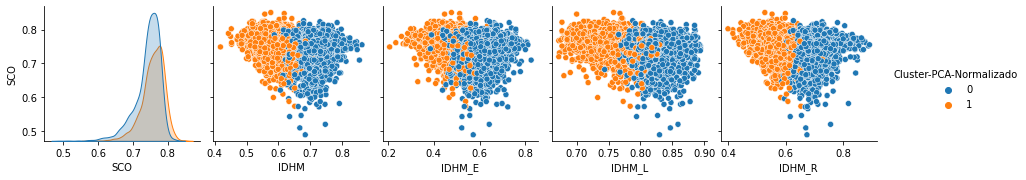

In [42]:
sns.pairplot(df,
            x_vars=['SCO','IDHM','IDHM_E','IDHM_L','IDHM_R'],
            y_vars= ['SCO'], hue='Cluster-PCA-Normalizado')

Conseguimos também verificar a participação de cada variável do dataset na composição dos 25 componentes principais:

In [43]:
print(pd.DataFrame(pca.components_,columns=df.iloc[:,6:-3].columns))

         SCO       TPM       DDM       SMM       POM       TPO       RSA  \
0   0.029378 -0.002803 -0.009611 -0.058329 -0.002677 -0.081263  0.242621   
1  -0.014386  0.005272  0.015509  0.025495  0.003454  0.014850 -0.022511   
2  -0.034127 -0.006268 -0.023322  0.014749 -0.004588 -0.003346 -0.094320   
3   0.147717  0.022050  0.049227  0.180871  0.017074  0.074909  0.020642   
4   0.026827  0.012233  0.033154  0.054139  0.011037  0.035825 -0.025019   
5  -0.136877 -0.007533 -0.028698 -0.079457 -0.005358 -0.045239  0.086078   
6   0.048478  0.013174  0.029493  0.071422  0.011607  0.067106  0.090612   
7  -0.258350 -0.016539 -0.023063 -0.048340 -0.015112  0.006171 -0.128855   
8   0.102560  0.018535  0.014677  0.181265  0.018730  0.156970 -0.144685   
9   0.085135 -0.015500  0.006781  0.057918 -0.015032  0.034315 -0.061676   
10  0.526881 -0.013680 -0.037845  0.004240 -0.009979  0.034769 -0.219304   
11 -0.530860 -0.016108 -0.051846 -0.127822 -0.013034 -0.072722 -0.129763   
12 -0.501883